<a href="https://colab.research.google.com/github/ShalilG/Stock-Market-Analysis/blob/main/S%26PBacktestMeanReversionUsingOOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29104 sha256=e40b8a771e3452c889ca8fee064180acc678951da375e40ef7569686e69d8a1d
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta


In [4]:
import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import ta

In [7]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol

In [8]:
tickers

0       MMM
1       AOS
2       ABT
3      ABBV
4      ABMD
       ... 
498     YUM
499    ZBRA
500     ZBH
501    ZION
502     ZTS
Name: Symbol, Length: 503, dtype: object

In [11]:
tickers_chg = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[1]

In [12]:
tickers_chg

Date  Added                                Removed  \
                  Date Ticker                       Security  Ticker   
0        June 21, 2022    KDP               Keurig Dr Pepper  UA/UAA   
1        June 21, 2022     ON               ON Semiconductor    IPGP   
2         June 8, 2022   VICI                Vici Properties    CERN   
3        April 4, 2022    CPT          Camden Property Trust    PBCT   
4        March 2, 2022    MOH              Molina Healthcare    INFO   
..                 ...    ...                            ...     ...   
301       June 9, 1999    WLP                      Wellpoint     HFI   
302  December 11, 1998    FSR                        Firstar     LDW   
303  December 11, 1998    CCL                 Carnival Corp.     GRE   
304  December 11, 1998   CPWR                      Compuware     SUN   
305      June 17, 1997    CCI  Countrywide Credit Industries     USL   

                                \
                      Security   
0                 Under Armour   
1                IPG Photonics   
2                       Cerner   
3    People's United Financial   
4                   IHS Markit   
..                         ...   
301   Harnischfeger Industries   
302                      Amoco   
303                 General Re   
304                 SunAmerica   
305                     USLife   

                                                Reason  
                                                Reason  
0                     Market capitalization change.[4]  
1                     Market capitalization change.[4]  
2    S&P 500 constituent Oracle Corp. acquired Cern...  
3    S&P 500 constituent M&T Bank Corp. acquired Pe...  
4    S&P 500 constituent S&P Global Inc. acquired I...  
..                                                 ...  
301           Harnischfeger filed for bankruptcy.[231]  
302            British Petroleum purchased Amoco.[232]  
303      Berkshire Hathaway purchased General Re.[232]  
304                     AIG purchased SunAmerica.[232]  
305                          AIG acquired USLife.[233]  

[306 rows x 6 columns]

In [15]:
pd.to_datetime(tickers_chg.Date.Date)

0     2022-06-21
1     2022-06-21
2     2022-06-08
3     2022-04-04
4     2022-03-02
         ...    
301   1999-06-09
302   1998-12-11
303   1998-12-11
304   1998-12-11
305   1997-06-17
Name: Date, Length: 306, dtype: datetime64[ns]

In [17]:
added = tickers_chg[pd.to_datetime(tickers_chg.Date.Date) >= '2019-01-01'].Added

In [18]:
removed = tickers_chg[pd.to_datetime(tickers_chg.Date.Date) >= '2019-01-01'].Removed

In [20]:
tickers = tickers[~(tickers.isin(added.Ticker))]

In [22]:
removed.iloc[0].Ticker = 'UAA'

In [23]:
removed

,Ticker,Security
0,UAA,Under Armour
1,IPGP,IPG Photonics
2,CERN,Cerner
3,PBCT,People's United Financial
4,INFO,IHS Markit
...,...,...
64,BHF,Brighthouse Financial
65,GT,The Goodyear Tire & Rubber Company
66,NFX,Newfield Exploration
67,PCG,Pacific Gas & Electric Company


In [25]:
tickers = tickers.append(removed.Ticker)

In [26]:
tickers.dropna(inplace=True)

In [27]:
tickers

0      MMM
1      AOS
2      ABT
3     ABBV
4     ABMD
      ... 
64     BHF
65      GT
66     NFX
67     PCG
68     SCG
Length: 504, dtype: object

In [28]:
tickers.drop_duplicates(inplace=True)

In [40]:
tickers.head(50)

0       MMM
1       AOS
2       ABT
3      ABBV
4      ABMD
5       ACN
6      ATVI
7       ADM
8      ADBE
9       ADP
10      AAP
11      AES
12      AFL
13        A
14      APD
15     AKAM
16      ALK
17      ALB
18      ARE
19     ALGN
20     ALLE
21      LNT
22      ALL
23    GOOGL
24     GOOG
25       MO
26     AMZN
28      AMD
29      AEE
30      AAL
31      AEP
32      AXP
33      AIG
34      AMT
35      AWK
36      AMP
37      ABC
38      AME
39     AMGN
40      APH
41      ADI
42     ANSS
43      AON
44      APA
45     AAPL
46     AMAT
47     APTV
48     ANET
49      AJG
50      AIZ
dtype: object

In [53]:
class Backtest:

  def __init__(self, symbol):
    self.symbol = symbol
    self.df = yf.download(self.symbol,start='2019-01-01')
    if self.df.empty:
      print('No data pulled')
    else: 
      self.calc_indicators()
      self.generate_signal()
      self.loop_it()
      self.profit = self.calc_profit()
      self.cumul_profit = (self.profit + 1).prod() - 1
      
  
  def calc_indicators(self):
    self.df['ma_20'] = self.df.Close.rolling(20).mean()
    self.df['vol'] = self.df.Close.rolling(20).std()
    self.df['upper_bb'] = self.df.ma_20 + (2*self.df.vol)
    self.df['lower_bb'] = self.df.ma_20 - (2*self.df.vol)
    self.df['rsi'] = ta.momentum.rsi(self.df.Close, window=6)
    self.df.dropna(inplace=True)

  def generate_signal(self):
    conditions = [(self.df.rsi < 30) & (self.df.Close < self.df.lower_bb),
                  (self.df.rsi > 70) & (self.df.Close > self.df.upper_bb)]
    choices = ['Buy','Sell']
    self.df['signal'] = np.select(conditions,choices)
    self.df.signal = self.df.signal.shift()
    self.df.dropna(inplace=True)
  
  def loop_it(self):
    position = False
    buydates,selldates = [],[]
  

    for index, row in self.df.iterrows():
      if not position and row['signal'] == 'Buy':
        buydates.append(index)
        position = True
      
      if position and row['signal'] == 'Sell':     
        selldates.append(index)
        position = False
    
    self.buy_arr = self.df.loc[buydates].Open
    self.sell_arr = self.df.loc[selldates].Open
  
  def calc_profit(self):
    if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
        self.buy_arr = self.buy_arr[:-1]
    return (self.sell_arr.values - self.buy_arr.values)/self.buy_arr.values
  
  def plot_chart(self):
    plt.figure(figsize=(10,5))
    plt.plot(self.df.Close)
    plt.scatter(self.buy_arr.index, self.buy_arr.values, marker='^', c='g')
    plt.scatter(self.sell_arr.index, self.sell_arr.values, marker='v', c='r')

In [54]:
instances = []

for ticker in tickers:
  instances.append(Backtest(ticker))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ACN: No data found for this date range, symbol may be delisted
No data pulled
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[**

IndexError: ignored

In [57]:
instances[0].cumul_profit

-0.0874486615386566

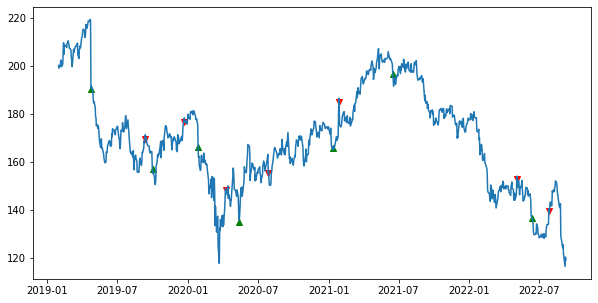

In [60]:
instances[0].plot_chart()

In [61]:
profits, comp_name = [],[]

for obj in instances:
  if not obj.df.empty:
    profits.append(obj.cumul_profit)
    comp_name.append(obj.symbol)

In [63]:
ret_frame = pd.DataFrame(profits, index=comp_name, columns=['cumul_ret'])

In [67]:
ret_frame.nlargest(10, 'cumul_ret')

,cumul_ret
BHF,2.099452
CAH,1.473687
HST,1.423358
CCI,1.332815
LH,1.314205
KLAC,1.306304
ETN,1.294508
AZO,1.250882
HOG,1.219855
NEM,1.154956


In [69]:
 tickers[tickers == 'BHF']

64    BHF
dtype: object

In [74]:
instances[499].profit

array([ 0.18023097,  0.03481095,  0.1185043 ,  0.11775406, -0.07662518,
        0.37850996, -0.00170908,  0.24529989,  0.13155771,  0.15779706,
       -0.02085993])

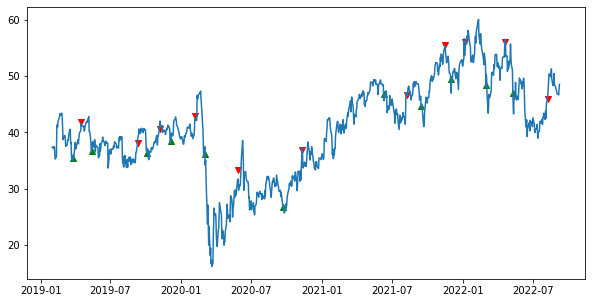

In [77]:
instances[499].plot_chart()

In [68]:
 ret_frame.nsmallest(10, 'cumul_ret')

,cumul_ret
NKTR,-0.756086
MAC,-0.700706
PARA,-0.688254
M,-0.639072
NFLX,-0.632752
BBWI,-0.631432
TRIP,-0.620802
GT,-0.605722
OXY,-0.592214
ALGN,-0.591646


In [78]:
tickers[tickers == 'NKTR']

54    NKTR
dtype: object

In [79]:
instances[489].profit

array([-0.07682362, -0.39190434,  0.35135129, -0.01791048, -0.03749994,
        0.03182578, -0.10253809, -0.10714285, -0.58860757])